In [1]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import imghdr

In [2]:
#limit RAM usage
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

#### Check extension compliance

In [3]:
DATA_PATH = 'data'
IMAGE_EXTS = ['jpeg','jpg','png']
sizes = []
labs = []

for image_class in os.listdir(DATA_PATH):
    labs.append(image_class)
    sizes.append(len(os.listdir(os.path.join(DATA_PATH,image_class))))
    for image in os.listdir(os.path.join(DATA_PATH,image_class)):
        img_path = os.path.join(DATA_PATH,image_class,image)
        try:
            img = cv2.imread(img_path)
            ext = imghdr.what(img_path)
            if ext not in IMAGE_EXTS:
                print(f"Invalid extension for image {img_path}")
                os.remove(img_path)
        except Exception as e:
            print(e)
            print(f"Encountered issue with image {img_path}")

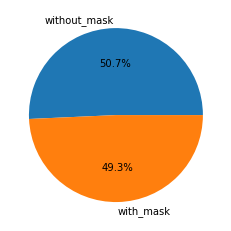

In [4]:
fig, ax = plt.subplots()
ax.pie(sizes, labels=labs, autopct='%1.1f%%')
plt.show()

#### Loading data

In [5]:
#CREATES A GENERATOR
train_data = tf.keras.preprocessing.image_dataset_from_directory(DATA_PATH,
                                                          batch_size =32,
                                                          seed = 123,
                                                          validation_split=0.2,
                                                          subset="training",
                                                          image_size=(256, 256),
                                                          shuffle=True)
val_data = tf.keras.preprocessing.image_dataset_from_directory(DATA_PATH,
                                                          batch_size =32,
                                                          seed = 123,
                                                          validation_split=0.2,
                                                          subset="validation",
                                                          image_size=(256, 256),
                                                          shuffle=True)
#print("DATA GENERATOR TYPE ",data)
#GRAB A DATA FROM GENERATOR
data_iterator = train_data.as_numpy_iterator()
#print("DATA ITERATOR TYPE ",data_iterator)
#USING .NEXT WE CAN GET CONSECUTIVE BATCHES. creates image representation and labels
batch = data_iterator.next()

Found 7548 files belonging to 2 classes.
Using 6039 files for training.
Found 7548 files belonging to 2 classes.
Using 1509 files for validation.


In [6]:
train_data.class_names

['with_mask', 'without_mask']

In [7]:
batch[0].shape

(32, 256, 256, 3)

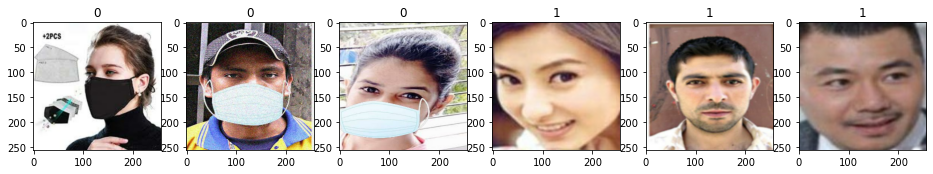

In [8]:
fig,ax = plt.subplots(ncols = 6, figsize = (16,16))
for id_x, img in enumerate(batch[0][:6]):
    ax[id_x].imshow(img.astype(int))
    ax[id_x].title.set_text(batch[1][id_x])

#### FLAG 1 - WITHOUT MASK, 0 - WITH MASK

#### SCALLING DATA AND TRAIN/TEST SPLIT

In [9]:
train_data = train_data.map(lambda x,y: (x/255,y))
train_scaled_iterator = train_data.as_numpy_iterator()
train_batch = train_scaled_iterator.next()

In [10]:
val_data = val_data.map(lambda x,y: (x/255,y))
val_scaled_iterator = val_data.as_numpy_iterator()
val_batch = val_scaled_iterator.next()

In [11]:
train_batch[0].shape

(32, 256, 256, 3)

In [12]:
print("MINIMUM:", train_batch[0].min(), "\nMAXIMUM", train_batch[0].max())

MINIMUM: 0.0 
MAXIMUM 1.0


In [13]:
print("MINIMUM:", val_batch[0].min(), "\nMAXIMUM", val_batch[0].max())

MINIMUM: 0.0 
MAXIMUM 1.0


#### MODEL BULDING

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten,Dropout

#conv2d - spatial convolution over images
#maxpooling - condensing layer, takes max value from the region
#Dense - fully connected layer
#Flatten - transforms Conv to format Dense layer will accept
#Dropout - regularization layer

In [15]:
model = Sequential()

In [16]:
#Model with 32 filters, stride 1
model.add(Conv2D(16, (5,5), strides = (1,1), input_shape = (256,256,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5,5), strides = (1,1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5,5), strides = (1,1),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 16)      6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 16)        6416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [17]:
#Binary classification problem
model.compile(optimizer='adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [18]:
#TRAIN
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [19]:
history = model.fit(train_data, 
                      epochs = 10, 
                      validation_data = val_data, 
                      callbacks = [tensorboard_callback])

Epoch 1/10
  1/189 [..............................] - ETA: 0s - loss: 0.7181 - accuracy: 0.4375WARNING:tensorflow:From C:\Users\woote\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
189/189 [==============================] - 252s 1s/step - loss: 0.3730 - accuracy: 0.8357 - val_loss: 0.3093 - val_accuracy: 0.8781
Epoch 2/10
189/189 [==============================] - 252s 1s/step - loss: 0.2258 - accuracy: 0.9131 - val_loss: 0.1913 - val_accuracy: 0.9264
Epoch 3/10
189/189 [==============================] - 282s 1s/step - loss: 0.1682 - accuracy: 0.9361 - val_loss: 0.2224 - val_accuracy: 0.9185
Epoch 4/10
189/189 [==============================] - 255s 1s/step - loss: 0.1471 - accuracy: 0.9445 - val_loss: 0.1947 - val_accuracy: 0.9390
Epoch 5/10
189/189 [==============================] - 255s 1s/

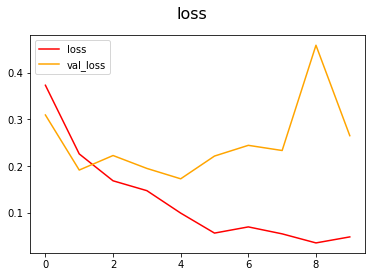

In [20]:
fig = plt.figure()
plt.plot(history.history['loss'], color='red', label = 'loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('loss', fontsize = 16)
plt.legend(loc='upper left')
plt.show()

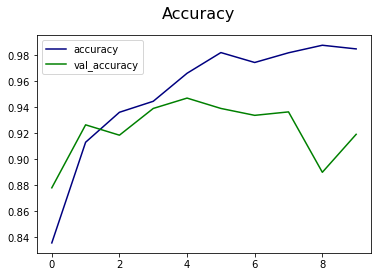

In [21]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='navy', label = 'accuracy')
plt.plot(history.history['val_accuracy'], color = 'green', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 16)
plt.legend(loc='upper left')
plt.show()

### Model nr 2

In [22]:
model2 = Sequential()
model2.add(Conv2D(16, (5,5), strides = (2,2), padding='same', input_shape = (256,256,3), activation = 'relu'))
model2.add(Conv2D(16, (5,5), strides = (2,2), padding='same', activation = 'relu'))
model2.add(Conv2D(16, (5,5), strides = (2,2), padding='same', activation = 'relu'))

model2.add(Flatten())

model2.add(Dense(256,activation = 'relu'))
model2.add(Dense(1,activation = 'sigmoid'))
model2.summary()

model2.compile(optimizer='adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

logdir = 'logs2'
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 16)      1216      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 16)        6416      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 16)        6416      
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 4,208,865
Trainable params: 4,208,865
Non-trainable params: 0
____________________________________________

In [23]:
history2 = model2.fit(train_data, 
                      epochs = 10, 
                      validation_data = val_data, 
                      callbacks = [tensorboard_callback2])

Epoch 1/10
189/189 [==============================] - 88s 463ms/step - loss: 0.3852 - accuracy: 0.8351 - val_loss: 0.2931 - val_accuracy: 0.9139
Epoch 2/10
189/189 [==============================] - 85s 451ms/step - loss: 0.2294 - accuracy: 0.9117 - val_loss: 0.2759 - val_accuracy: 0.8854
Epoch 3/10
189/189 [==============================] - 85s 448ms/step - loss: 0.1795 - accuracy: 0.9353 - val_loss: 0.3066 - val_accuracy: 0.8953
Epoch 4/10
189/189 [==============================] - 85s 447ms/step - loss: 0.1366 - accuracy: 0.9500 - val_loss: 0.2062 - val_accuracy: 0.9364
Epoch 5/10
189/189 [==============================] - 86s 453ms/step - loss: 0.0947 - accuracy: 0.9647 - val_loss: 0.2254 - val_accuracy: 0.9417
Epoch 6/10
189/189 [==============================] - 86s 454ms/step - loss: 0.0650 - accuracy: 0.9778 - val_loss: 0.2267 - val_accuracy: 0.9317
Epoch 7/10
189/189 [==============================] - 86s 457ms/step - loss: 0.0545 - accuracy: 0.9801 - val_loss: 0.2417 - val_ac

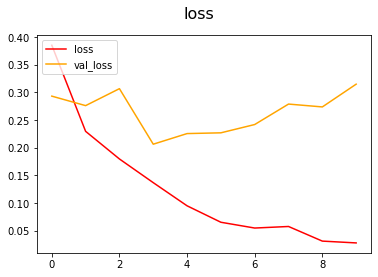

In [24]:
fig = plt.figure()
plt.plot(history2.history['loss'], color='red', label = 'loss')
plt.plot(history2.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('loss', fontsize = 16)
plt.legend(loc='upper left')
plt.show()

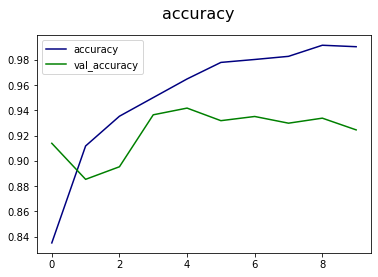

In [25]:
fig = plt.figure()
plt.plot(history2.history['accuracy'], color='navy', label = 'accuracy')
plt.plot(history2.history['val_accuracy'], color = 'green', label = 'val_accuracy')
fig.suptitle('accuracy', fontsize = 16)
plt.legend(loc='upper left')
plt.show()

#### Model nr 3

In [26]:
model3 = Sequential()

model3.add(Conv2D(16, (5,5), strides = (2,2), padding='same', input_shape = (256,256,3), activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Conv2D(16, (5,5), strides = (2,2), padding='same', activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Conv2D(16, (5,5), strides = (2,2), padding='same', activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Conv2D(32, (3,3), strides = (2,2), padding='same', activation = 'relu'))
model3.add(Dropout(0.2))

model3.add(Flatten())
model3.add(Dense(512, activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation = 'sigmoid'))
model3.summary()

model3.compile(optimizer='adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

logdir = 'logs3'
tensorboard_callback3 = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 16)      1216      
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 16)        6416      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 16)        6416      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)       

In [27]:
history3 = model3.fit(train_data, 
                      epochs = 10, 
                      validation_data = val_data, 
                      callbacks = [tensorboard_callback3])

Epoch 1/10
189/189 [==============================] - 114s 604ms/step - loss: 0.5406 - accuracy: 0.6955 - val_loss: 0.2818 - val_accuracy: 0.8847
Epoch 2/10
189/189 [==============================] - 113s 598ms/step - loss: 0.2973 - accuracy: 0.8793 - val_loss: 0.2253 - val_accuracy: 0.9099
Epoch 3/10
189/189 [==============================] - 112s 595ms/step - loss: 0.2506 - accuracy: 0.9005 - val_loss: 0.1879 - val_accuracy: 0.9284
Epoch 4/10
189/189 [==============================] - 113s 600ms/step - loss: 0.2017 - accuracy: 0.9253 - val_loss: 0.1845 - val_accuracy: 0.9284
Epoch 5/10
189/189 [==============================] - 289s 2s/step - loss: 0.1701 - accuracy: 0.9381 - val_loss: 0.1767 - val_accuracy: 0.9298
Epoch 6/10
189/189 [==============================] - 109s 579ms/step - loss: 0.1498 - accuracy: 0.9462 - val_loss: 0.1693 - val_accuracy: 0.9324
Epoch 7/10
189/189 [==============================] - 97s 513ms/step - loss: 0.1542 - accuracy: 0.9434 - val_loss: 0.1619 - val

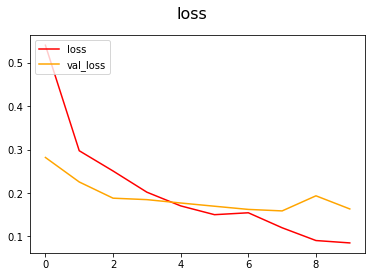

In [28]:
fig = plt.figure()
plt.plot(history3.history['loss'], color='red', label = 'loss')
plt.plot(history3.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('loss', fontsize = 16)
plt.legend(loc='upper left')
plt.show()

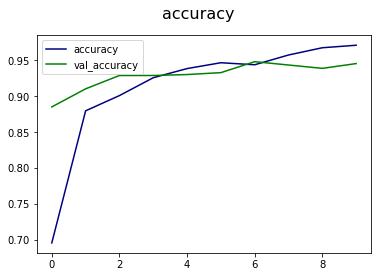

In [29]:
fig = plt.figure()
plt.plot(history3.history['accuracy'], color='navy', label = 'accuracy')
plt.plot(history3.history['val_accuracy'], color = 'green', label = 'val_accuracy')
fig.suptitle('accuracy', fontsize = 16)
plt.legend(loc='upper left')
plt.show()

#### Comparison

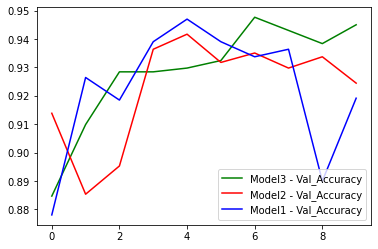

In [75]:
fig = plt.figure()
plt.plot(history3.history['val_accuracy'], color='green', label = 'Model3 - Val_Accuracy')
plt.plot(history2.history['val_accuracy'], color='red', label = 'Model2 - Val_Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label = 'Model1 - Val_Accuracy')
plt.legend(loc='lower right')
plt.show()

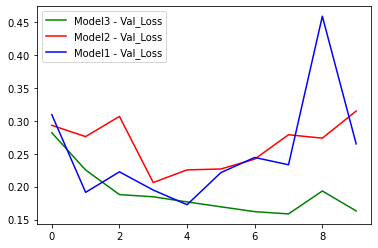

In [77]:
fig = plt.figure()
plt.plot(history3.history['val_loss'], color='green', label = 'Model3 - Val_Loss')
plt.plot(history2.history['val_loss'], color='red', label = 'Model2 - Val_Loss')
plt.plot(history.history['val_loss'], color='blue', label = 'Model1 - Val_Loss')
plt.legend(loc='upper left')
plt.show()

#### PREDICT ON OWN EXAMPLE

In [42]:
 def prediction(yhat):
    if yhat > 0.5:
        print("Predicted value: without mask")
    else:
        print("Predicted value: with mask")

In [45]:
img_with = cv2.imread('test_data/test_with.jpg')
# plt.imshow(cv2.cvtColor(img_with,cv2.COLOR_BGR2RGB))
# plt.show()
resized_with = tf.image.resize(img_with,(256,256))
yhat1 = model3.predict(np.expand_dims(resized_with/255,0))
print(np.expand_dims(resized_with/255,0).shape)
prediction(yhat1)

(1, 256, 256, 3)
Predicted value: with mask


In [65]:
img_without = cv2.imread('test_data/test_without.jpg')
resized_without = tf.image.resize(img_without,(256,256))
# plt.imshow(resized_without.numpy().astype(int))
# plt.show()
yhat2 = model3.predict(np.expand_dims(resized_without/255,0))
print(np.expand_dims(resized_without/255,0).shape)
prediction(yhat2)

(1, 256, 256, 3)
Predicted value: without mask


#### Save the model

In [66]:
from tensorflow.keras.models import load_model

In [67]:
model3.save(os.path.join('models','with_without_mask.h5'))

In [68]:
model_load = load_model(os.path.join('models','with_without_mask.h5'))

In [69]:
img_without = cv2.imread('test_data/test_without.jpg')
resized_without = tf.image.resize(img_without,(256,256))
yhat2 = model_load.predict(np.expand_dims(resized_without/255,0))
print(np.expand_dims(resized_without/255,0).shape)
prediction(yhat2)

(1, 256, 256, 3)
Predicted value: without mask
